## Compute expected loss of energy in Lagrangian perspective

In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

import os
from glob import glob
import threading

import dask.dataframe as dd
from dask import delayed
import pandas as pd
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [3]:
def get_lagrangian_energy_loss(omega, bandwidth, ds, U=1, 
                               Ce=None,axis=-1, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
#    U = 1
    
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Ce is None:
        Ce = lambda tau, U, T: 2*U * np.exp(-np.abs(tau/T)) * np.cos(2*np.pi*omega*tau)
        
    # derives Lagrangian
#    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    sigma = lambda tau, Ub, Tb: (Tb*day2sec*Ub)*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- (sigma(tau, Ub, Tb)*k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Ce"] = Ce(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Cl"] = Cl(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)
    # build power density spectrum
    N = ds.tau.size
    if axis==-1:
        input_dims_Ce, input_dims_Cl = ["tau"],["tau"]
        output_dims_Ce, output_dims_Cl = ["omega"], ["omega"]
    elif axis==0:
        dim = 'k'
        input_dims_Ce = ["tau"]#[d for d in ds.Ce.dims]
        output_dims_Ce = ["omega"]#+[d for d in ds.Ce.dims[1:]]
    
        input_dims_Cl = ["tau","k"]#[d for d in ds.Cl.dims]
        output_dims_Cl = ["omega","k"]#+[d for d in ds.Cl.dims[1:]]
    print(input_dims_Cl,output_dims_Cl)
    def dct(C,input_dims,output_dims):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3,axis=axis) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[input_dims],
                              output_core_dims=[output_dims],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    
    ds["Ee"] = dct(ds.Ce,input_dims_Ce,output_dims_Ce)
    ds["El"] = dct(ds.Cl,input_dims_Cl,output_dims_Cl)
#    ds["Ee"] = xr.DataArray(fft.dct(ds.Ce.values,type=3,axis=axis)*dtau)
#    ds["El"] = fft.dct(ds.Cl.values,type=3,axis=axis)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau

    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return Ee,El,ds.ratio

In [4]:
# wave
omega = 2 # cpd
T = 40. # days
k = 2*np.pi/100e3 # rad/m

# slow flow
Ubar = np.arange(0.01,10,.01) # m/s
Tbar = 10 # days

# filter
bandwidth = 0.4 # cpd

#### Varying  decorrelation timescale and tau max

In [27]:
T = 40
#Te = np.arange(10,50,1)
ds = xr.Dataset(dict(T=T, k=k, Ubar=("x", Ubar), Tbar=Tbar))
# x is here for technical reasons and may represent lon, lat for instance
#ds = ds.chunk(dict(x=-1)) # dask test

#out = get_lagrangian_energy_loss(omega, bandwidth, ds,full_output=True)
#Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=1)
ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10,full_output=True)
ratio = ratio.swap_dims(dict(x="Ubar"))
#El = El.swap_dims(dict(x="Ubar"))

Ee_10,El_10,ratio_10 = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10)
ratio_10 = ratio_10.swap_dims(dict(x="Ubar"))
El_10 = El_10.swap_dims(dict(x="Ubar"))

Ee_100,El_100,ratio_100 = get_lagrangian_energy_loss(omega, bandwidth, ds)
ratio_100 = ratio_100.swap_dims(dict(x="Ubar"))
El_100 = El_100.swap_dims(dict(x="Ubar"))

['tau'] ['omega']
['tau'] ['omega']
['tau'] ['omega']


In [28]:
El_10.compute()

<xarray.DataArray 'El' (Ubar: 999)>
array([0.98731577, 0.98714401, 0.98683544, 0.9863458 , 0.98557953,
       0.98432072, 0.98211403, 0.97820518, 0.97171384, 0.96197174,
       0.94875383, 0.93227866, 0.91306255, 0.89175101, 0.86899286,
       0.84536851, 0.82136026, 0.79734837, 0.77362029, 0.75038501,
       0.72778815, 0.70592584, 0.68485635, 0.66460965, 0.64519493,
       0.62660635, 0.60882751, 0.59183481, 0.57559993, 0.5600917 ,
       0.54527741, 0.53112385, 0.51759799, 0.50466744, 0.49230084,
       0.48046801, 0.46914015, 0.45828986, 0.44789117, 0.43791956,
       0.4283519 , 0.41916641, 0.41034262, 0.40186128, 0.39370433,
       0.3858548 , 0.37829679, 0.37101533, 0.36399641, 0.35722685,
       0.35069428, 0.34438708, 0.33829432, 0.33240575, 0.32671168,
       0.32120302, 0.31587122, 0.3107082 , 0.30570634, 0.30085848,
       0.29615783, 0.29159799, 0.28717293, 0.28287691, 0.27870454,
       0.27465068, 0.2707105 , 0.26687938, 0.26315298, 0.25952715,
       0.25599797, 0.25256171, 0.24921482, 0.24595393, 0.24277583,
       0.23967747, 0.23665595, 0.23370848, 0.23083243, 0.22802528,
       0.22528463, 0.22260818, 0.21999373, 0.2174392 , 0.21494257,
       0.21250194, 0.21011548, 0.20778142, 0.2054981 , 0.2032639 ,
       0.20107729, 0.19893678, 0.19684097, 0.19478851, 0.19277808,
       0.19080845, 0.18887841, 0.18698682, 0.18513258, 0.18331463,
...
       0.03850969, 0.03847295, 0.03843629, 0.03839969, 0.03836317,
       0.03832673, 0.03829035, 0.03825405, 0.03821783, 0.03818167,
       0.03814559, 0.03810958, 0.03807365, 0.03803779, 0.038002  ,
       0.03796628, 0.03793063, 0.03789506, 0.03785956, 0.03782413,
       0.03778877, 0.03775348, 0.03771827, 0.03768312, 0.03764805,
       0.03761305, 0.03757812, 0.03754326, 0.03750848, 0.03747376,
       0.03743911, 0.03740454, 0.03737004, 0.0373356 , 0.03730124,
       0.03726695, 0.03723272, 0.03719857, 0.03716449, 0.03713048,
       0.03709653, 0.03706266, 0.03702886, 0.03699512, 0.03696146,
       0.03692786, 0.03689434, 0.03686088, 0.03682749, 0.03679417,
       0.03676093, 0.03672774, 0.03669463, 0.03666159, 0.03662861,
       0.03659571, 0.03656287, 0.0365301 , 0.0364974 , 0.03646476,
       0.0364322 , 0.0363997 , 0.03636727, 0.03633491, 0.03630261,
       0.03627039, 0.03623823, 0.03620614, 0.03617411, 0.03614215,
       0.03611026, 0.03607844, 0.03604668, 0.03601499, 0.03598337,
       0.03595181, 0.03592032, 0.0358889 , 0.03585754, 0.03582625,
       0.03579503, 0.03576387, 0.03573278, 0.03570175, 0.03567079,
       0.0356399 , 0.03560907, 0.03557831, 0.03554761, 0.03551698,
       0.03548641, 0.03545591, 0.03542548, 0.03539511, 0.0353648 ,
       0.03533456, 0.03530439, 0.03527428, 0.03524423])
Coordinates:
    T        int64 40
    k        float64 6.283e-05
  * Ubar     (Ubar) float64 0.01 0.02 0.03 0.04 0.05 ... 9.96 9.97 9.98 9.99
    Tbar     int64 10

In [9]:
omega_array = ratio.omega
tau = ratio.tau
dtau = 2*np.pi/omega/100
N = tau.size
omega_bis = (2*np.arange(N)+1)/4/N /dtau

In [10]:
Ce = lambda tau,U,T : 2*U*np.exp(-tau/T)*np.cos(2*np.pi*omega*tau)

In [30]:
Te = np.arange(30,50,1)
ds = xr.Dataset(dict(T=Te, k=k, Ubar=("x", Ubar), Tbar=Tbar))

In [31]:
tau_max = T*10
dtau = 2*np.pi/omega/100
ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))

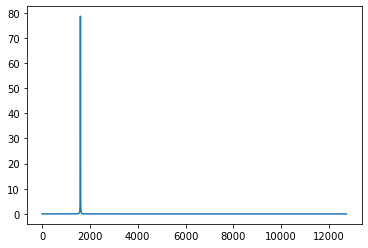

In [32]:
plt.plot((fft.dct(Ce(ds.tau,1,ds.T).values,type=3,axis=0)*dtau)[:,10])

In [33]:
ds = ds.chunk({'x':-1,'T':5})

In [34]:
test  = xr.Dataset({'spectra': (["omega","T"],fft.dct(Ce(ds.tau,1,ds.T).values,type=3,axis=0)*dtau
                               )}).assign_coords({"omega":omega_bis,"T":ds.T})

In [35]:
test.chunks

Frozen({})

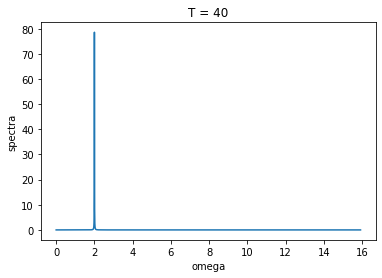

In [36]:
test.spectra.sel(T=40).plot()

In [37]:
ds_int = test.where( np.abs(test.omega-omega)<0.4/2, other=0 ).integrate("omega")

In [38]:
dt = 1e-4
ds_int.where((ds_int<=Ee_10.values+dt)&(ds_int>=Ee_10.values-dt),drop=True)

<xarray.Dataset>
Dimensions:  (T: 1)
Coordinates:
  * T        (T) int64 40
Data variables:
    spectra  (T) float64 0.9874

In [39]:
ds = xr.Dataset(dict(T=Te, k=k, Ubar=("x", Ubar), Tbar=Tbar))

In [48]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10,axis=0)

['tau', 'T'] ['omega', 'T']


In [50]:
El

<xarray.DataArray 'El' (x: 999, T: 20)>
array([[-8.47944039e-06, -8.93283751e-06, -9.38013017e-06, ...,
        -1.52311132e-05, -1.55637135e-05, -1.58896346e-05],
       [-8.47943469e-06, -8.93283152e-06, -9.38012389e-06, ...,
        -1.52311032e-05, -1.55637033e-05, -1.58896241e-05],
       [-8.47942329e-06, -8.93281953e-06, -9.38011132e-06, ...,
        -1.52310831e-05, -1.55636828e-05, -1.58896033e-05],
       ...,
       [-7.34909057e-06, -7.74416774e-06, -8.13403524e-06, ...,
        -1.32420443e-05, -1.35327933e-05, -1.38177378e-05],
       [-7.34907961e-06, -7.74415621e-06, -8.13402316e-06, ...,
        -1.32420250e-05, -1.35327736e-05, -1.38177177e-05],
       [-7.34907413e-06, -7.74415045e-06, -8.13401712e-06, ...,
        -1.32420154e-05, -1.35327638e-05, -1.38177076e-05]])
Coordinates:
  * T        (T) int64 30 31 32 33 34 35 36 37 38 ... 41 42 43 44 45 46 47 48 49
    k        float64 6.283e-05
    Ubar     (x) float64 0.01 0.02 0.03 0.04 0.05 ... 9.95 9.96 9.97 9.98 9.99
    Tbar     int64 10
Dimensions without coordinates: x

In [72]:
dt = 1e-4
Ee.where((Ee<=Ee_10.values+dt)&(Ee>=Ee_10.values-dt),drop=True)

<xarray.DataArray 'Ee' (T: 1)>
array([0.98737096])
Coordinates:
  * T        (T) int64 40
    k        float64 6.283e-05
    Tbar     int64 10

In [73]:
L = np.arange(50e3,150e3,10e3)
k = 2*np.pi/L
k

array([1.25663706e-04, 1.04719755e-04, 8.97597901e-05, 7.85398163e-05,
       6.98131701e-05, 6.28318531e-05, 5.71198664e-05, 5.23598776e-05,
       4.83321947e-05, 4.48798951e-05])

In [74]:
ds = xr.Dataset(dict(T=T, k=k, Ubar=("Ubar", Ubar), Tbar=Tbar))
ds# = ds.chunk(Ubar=-1)

<xarray.Dataset>
Dimensions:  (k: 10, Ubar: 100)
Coordinates:
  * k        (k) float64 0.0001257 0.0001047 8.976e-05 ... 4.833e-05 4.488e-05
  * Ubar     (Ubar) float64 0.01 0.11 0.21 0.31 0.41 ... 9.61 9.71 9.81 9.91
Data variables:
    T        int64 40
    Tbar     int64 10

In [75]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds,_factor_tau_max=10,axis=0)

['tau', 'Ubar', 'k'] ['omega', 'Ubar', 'k']


In [76]:
El

<xarray.DataArray 'El' (Ubar: 100, k: 10)>
array([[0.98714401, 0.9872151 , 0.98725722, 0.98728426, 0.98730267,
        0.98731577, 0.98732544, 0.98733276, 0.98733846, 0.98734296],
       [0.70592584, 0.78939569, 0.85217664, 0.89723907, 0.92822352,
        0.94875383, 0.96197174, 0.97032803, 0.97557923, 0.97890187],
       [0.41916641, 0.49230084, 0.5600917 , 0.62208654, 0.67801521,
        0.72778815, 0.77148503, 0.80933478, 0.84168925, 0.86899286],
       [0.29159799, 0.34646513, 0.39949838, 0.45044987, 0.49910337,
        0.54527741, 0.58882753, 0.62964766, 0.66767041, 0.7028664 ],
       [0.22260818, 0.26562582, 0.30783073, 0.34909679, 0.38930657,
        0.4283519 , 0.46613474, 0.50256801, 0.53757627, 0.57109627],
       [0.17978359, 0.21494257, 0.2496876 , 0.28393912, 0.31762935,
        0.35069428, 0.38307351, 0.41471053, 0.44555299, 0.47555301],
       [0.15081358, 0.18036262, 0.20977887, 0.238915  , 0.26772154,
        0.29615783, 0.32418529, 0.35176708, 0.37886817, 0.40545539],
       [0.13033638, 0.1553826 , 0.18077851, 0.20606426, 0.23114855,
        0.25599797, 0.28058608, 0.30488786, 0.32887928, 0.35253723],
       [0.11572972, 0.13673305, 0.15882901, 0.18109169, 0.2032639 ,
        0.22528463, 0.24712996, 0.26878158, 0.29022235, 0.31143573],
       [0.10535718, 0.12265676, 0.14178581, 0.16151997, 0.18133602,
        0.20107729, 0.22070073, 0.24018845, 0.25952715, 0.27870454],
...
       [0.02551393, 0.02674786, 0.0289878 , 0.03192327, 0.03518102,
        0.03850969, 0.04178116, 0.04494028, 0.04796544, 0.05084847],
       [0.02547571, 0.02663387, 0.02878586, 0.03164782, 0.03485302,
        0.03814559, 0.04139144, 0.04453153, 0.04754233, 0.05041481],
       [0.02544095, 0.02652681, 0.02859248, 0.03138089, 0.03453289,
        0.03778877, 0.04100862, 0.04412943, 0.04712561, 0.04998725],
       [0.02540938, 0.02642632, 0.02840741, 0.03112233, 0.03422052,
        0.03743911, 0.04063258, 0.04373384, 0.04671519, 0.04956571],
       [0.02538075, 0.02633211, 0.02823042, 0.03087199, 0.03391581,
        0.03709653, 0.04026322, 0.04334468, 0.04631095, 0.0491501 ],
       [0.0253548 , 0.02624385, 0.02806127, 0.03062974, 0.03361865,
        0.03676093, 0.03990043, 0.04296182, 0.04591281, 0.04874035],
       [0.02533132, 0.02616125, 0.02789973, 0.03039542, 0.03332894,
        0.0364322 , 0.03954412, 0.04258517, 0.04552065, 0.04833636],
       [0.02531011, 0.02608402, 0.02774555, 0.03016888, 0.03304659,
        0.03611026, 0.03919417, 0.04221462, 0.0451344 , 0.04793804],
       [0.02529096, 0.02601187, 0.02759851, 0.02994998, 0.0327715 ,
        0.03579503, 0.03885051, 0.04185008, 0.04475394, 0.04754533],
       [0.0252737 , 0.02594453, 0.02745837, 0.02973856, 0.03250356,
        0.03548641, 0.03851304, 0.04149146, 0.0443792 , 0.04715813]])
Coordinates:
    T        int64 40
  * k        (k) float64 0.0001257 0.0001047 8.976e-05 ... 4.833e-05 4.488e-05
  * Ubar     (Ubar) float64 0.01 0.11 0.21 0.31 0.41 ... 9.61 9.71 9.81 9.91
    Tbar     int64 10

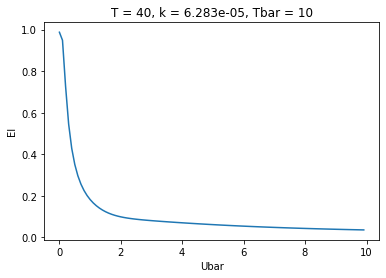

In [77]:
El_10.plot()

In [78]:
np.abs(El-El_10.compute()).argmin('k')

<xarray.DataArray 'El' (Ubar: 100)>
array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
Coordinates:
    T        int64 40
  * Ubar     (Ubar) float64 0.01 0.11 0.21 0.31 0.41 ... 9.61 9.71 9.81 9.91
    Tbar     int64 10

In [79]:
k_eff = 2*np.pi*1e-3/El.isel(k=np.abs(El-El_10.compute()).argmin('k')).k
#2*np.pi/El.where(np.abs(El-El_10.compute())==np.abs(El-El_10.compute()).min('k'),drop=True).k

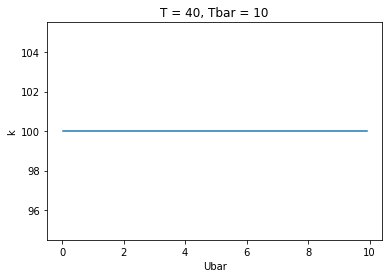

In [80]:
k_eff.plot()

#### LLC4320

In [5]:
#root_path = '/Users/zcaspar/codes/mit4320/'
root_path = '/home1/datawork/zcaspar/mit4320/'
#low :
file_E = root_path +'binned_Ecov_low_dl2.nc'
file_L = root_path +'binned_Lcov_low_dl2_flag10.nc'

dsE_low = xr.open_dataset(file_E)
dsL_low = xr.open_dataset(file_L)
#low_dl2 = xr.open_dataset(root_path+'variance_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins
low_dl2 = xr.open_dataset(root_path+'variance_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins
low_dl2_SSV = xr.open_dataset(root_path+'variance_SSV_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins

#tide
file_E = root_path +'binned_Ecov_uu_dl2.nc'
file_L = root_path +'binned_Lcov_uu_dl2_flag10.nc'

dsE = xr.open_dataset(file_E)
dsL = xr.open_dataset(file_L)
dsE_SSV = xr.open_dataset(root_path +'binned_Ecov_vv_dl2.nc')
dsL_SSV = xr.open_dataset(root_path +'binned_Lcov_vv_dl2_flag10.nc')

hf_dl2 = xr.open_dataset(root_path+'energy_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})
# Tidal variance, 2°bins


#path = '/Users/zcaspar/codes/Diagnostics/'+run#local



In [6]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag

In [7]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [8]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [9]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [10]:
def y_fit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)

def y_fit_low(tau,T,V):
    return V*np.exp(-tau/T)

In [11]:
dsE_low = dsE_low.where(dsE_low.rr.isel(lags=0)>0)
dsL_low = dsL_low.isel(lags=slice(0,None,3))

In [12]:
sigma = np.ones(tau.size)
sigma[0] = 0.1

In [13]:
dsE_low_out = wrapper(dsE_low,'rr',y_fit_low,tau,p0='lag',sigma=sigma,bounds=([1,0],[np.inf,np.inf]))
dsL_low_out = wrapper(dsL_low,'rr',y_fit_low,tau,p0='lag',sigma=sigma,bounds=([1,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [14]:
import cartopy.crs as ccrs
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,central_longitude=0,**kwargs):
    crs = ccrs.Robinson(central_longitude=central_longitude)
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,**kwargs,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    return fig,ax

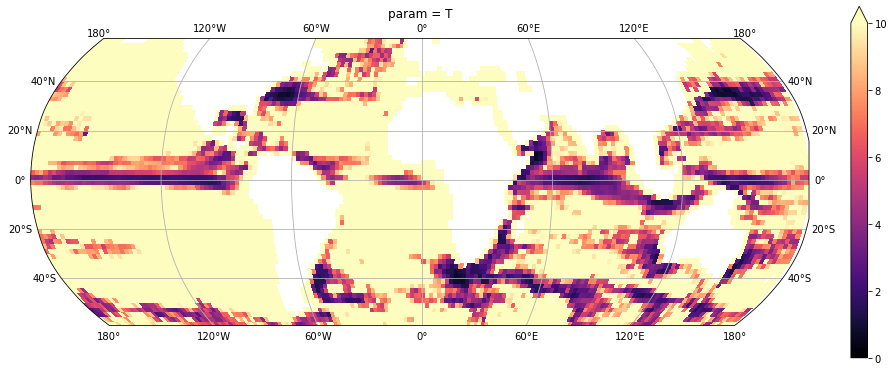

In [15]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(dsE_low_out.sel(param='T').error/dsE_low_out.sel(param='T').parameters
                   ,colmap='magma',vlim=(0,10))

#fig = plt.figure(figsize=(15,15))
#fig,ax = plot_maps(dsL_low_out.sel(param='T').error/dsL_low_out.sel(param='T').parameters
#                   ,colmap='magma',vlim=(0,10))

In [16]:
dsE = dsE.where(dsE.rr.isel(lags=0)>0)
dsL = dsL.isel(lags=slice(0,None,3))

In [17]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,bounds=([2.5,0],[np.inf,np.inf]))
dsL_out = wrapper(dsL,'rr',y_fit,tau,bounds=([2.5,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']
Parameters to estimate: ['T', 'V']


In [18]:
# Timescales
Te = dsE_out.sel(param='T').parameters.values
Tl = dsL_out.sel(param='T').parameters.values
Tlbar = dsL_low_out.sel(param='T').parameters.values
Tebar = dsE_low_out.sel(param='T').parameters.values

Ulbar = dsL_low.rr.isel(lags=0).values
Uebar = dsE_low.rr.isel(lags=0).values
#dsL_low_out.sel(param='V').parameters.values
Ubar = low_dl2.L_variance_SSU.values
Uebar = low_dl2.E_variance_SSU.values
U = dsE.rr.isel(lags=0).values
U_bis = hf_dl2.E_energy_SSU.values
#dsE_out.sel(param='V').parameters.values
#Ul = dsL_out.sel(param='V').parameters.values

In [21]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
L = np.arange(10e3,500e3,10e3)
#k = 2*np.pi/L # rad/m
k = 2*np.pi/100e3 # rad/m

# filter
bandwidth = 0.4 # cpd

In [29]:
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar)),
                     Tbar=(["lon",'lat'], Tebar), U=(["lon",'lat'], U_bis)))
ds = ds.chunk({"lon":10,'lat':10})
#ds_V = xr.Dataset(dict(T=(["lon",'lat'],Te_SSV), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar_SSV)),
#                     Tbar=(["lon",'lat'], Tlbar_SSV.T), U=(["lon",'lat'], U_SSV)))

In [30]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']


In [31]:
ds_predict = xr.Dataset({'Ee':Ee.compute(),'El':El.compute(),'ratio':ratio.compute()})
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

Text(0.5, 1.0, 'Eulerian estimation ratio')

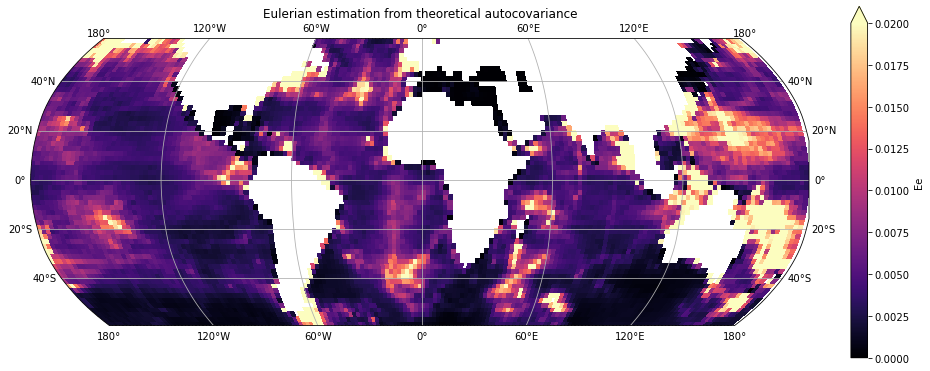

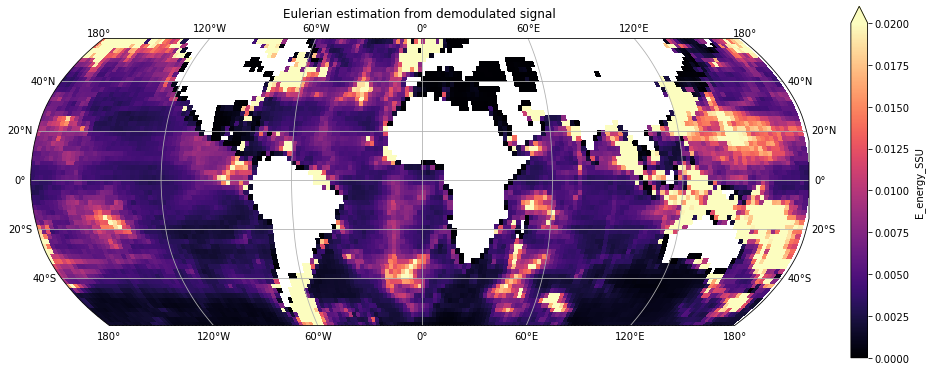

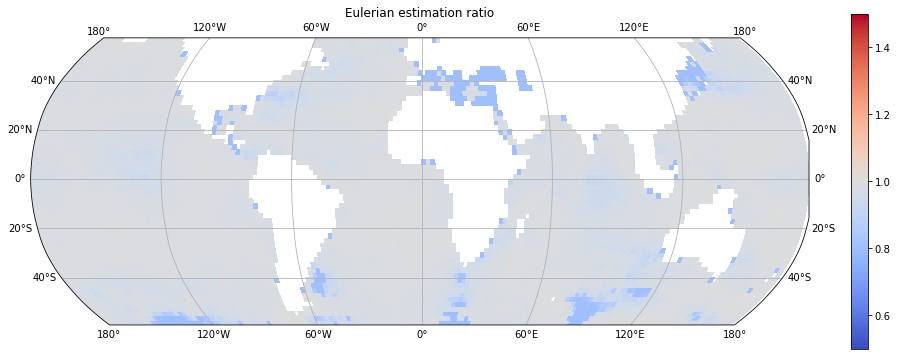

In [32]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.E_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Eulerian estimation ratio')

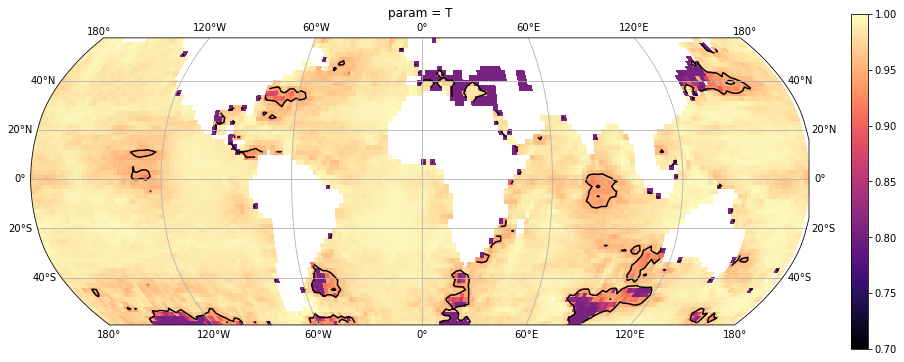

In [33]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='magma',vlim=(0.7,1.))
ax.set_title('Eulerian estimation ratio')
dsE_out.sel(param='T').parameters.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

Text(0.5, 1.0, 'Lagrangian estimation ratio')

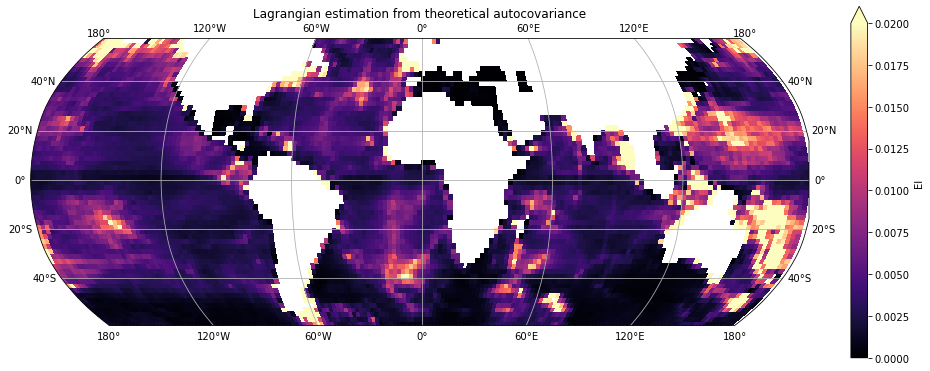

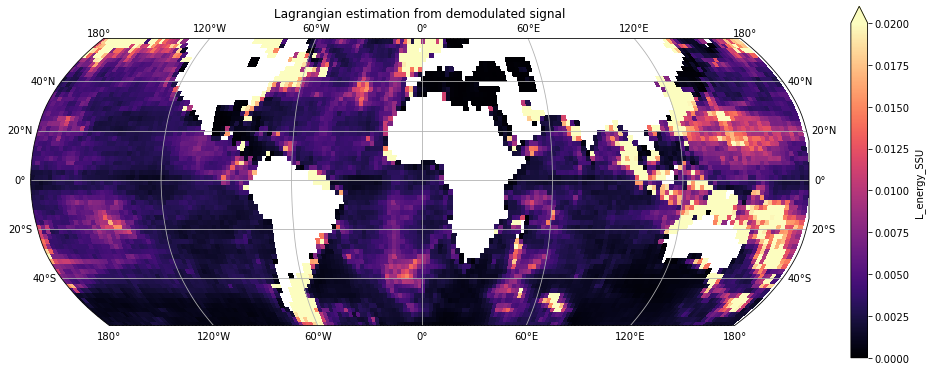

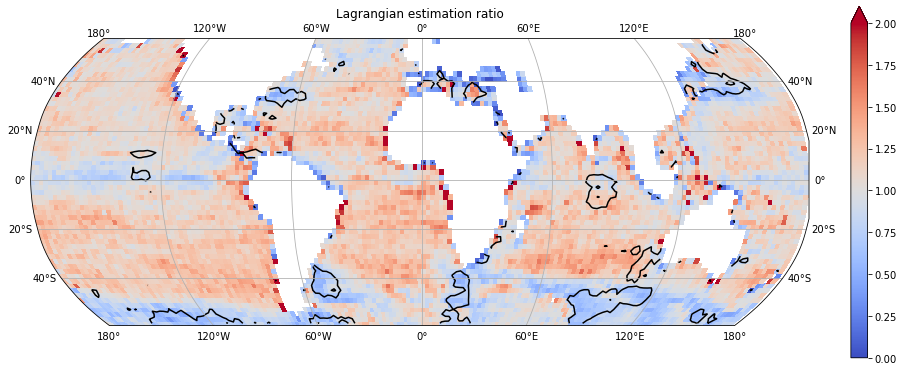

In [34]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))
dsE_out.sel(param='T').parameters.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

ax.set_title('Lagrangian estimation ratio')

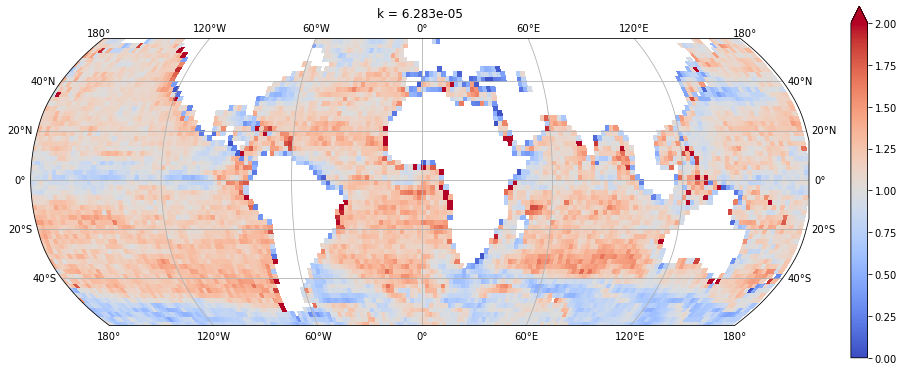

In [35]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((ds_predict.El/ds_predict.Ee)/(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU)
                   ,colmap='coolwarm',vlim=(0,2))



In [28]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
L = np.arange(1e3,1000e3,20e3)
k = 2*np.pi/L # rad/m


# filter
bandwidth = 0.4 # cpd
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar)),
                     Tbar=(["lon",'lat'], Tebar), U=(["lon",'lat'], U_bis)))
ds = ds.chunk({"lon":10,'lat':10,'k':-1})


ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59, k: 50)
Coordinates:
  * k        (k) float64 0.006283 0.0002992 0.0001532 ... 6.538e-06 6.405e-06
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [29]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']


In [30]:
ds_predict = xr.Dataset({'Ee':Ee.compute(),'El':El.compute(),'ratio':ratio.compute()})
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 10.70 GiB -- Worker memory limit: 12.50 GiB
distributed.worker - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 9.84 GiB -- Worker memory limit: 12.50 GiB
distributed.worker - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 10.83 GiB -- Worker memory limit: 12.50 GiB
distributed.worker - WARNING - Worker is at 81% memory usage. Resuming worker. Process memory: 10.22 GiB -- Worker memory limit: 12.50 GiB
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 10.64 GiB -- Worker memory limit: 12.50 GiB
distributed.worker - WARNING - Worker is at 80% memory usage. Resuming worker. Process memory: 10.06 GiB -- Worker memory limit: 12.50 GiB
distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memo

In [31]:
El_true = hf_dl2.L_energy_SSU

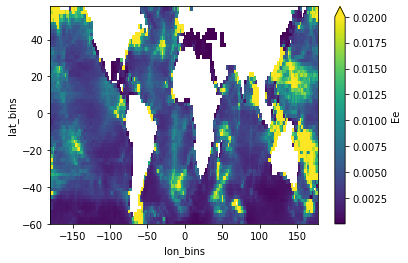

In [32]:
ds_predict.Ee.plot(y='lat_bins',vmax=0.02)

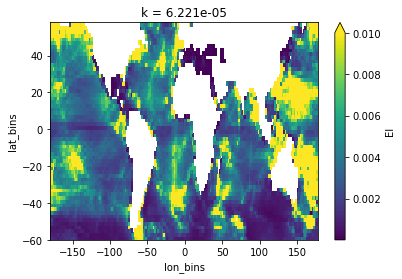

In [33]:
ds_predict.El.isel(k=5).plot(y='lat_bins',vmax=0.01)

In [34]:
id_min = np.abs(ds_predict.El-El_true).idxmin('k',skipna=False)
#ds_predict.k#.isel(k=np.abs(ds_predict.El-El_true).argmin('k',skipna=False).values)
#.plot(y='lat_bins')

In [35]:
id_min

<xarray.DataArray 'k' (lon_bins: 179, lat_bins: 59)>
array([[7.75701890e-05, 6.22097555e-05, 3.12596284e-05, ...,
        1.03003038e-04, 7.75701890e-05, 1.03003038e-04],
       [6.22097555e-05, 3.90259957e-05, 3.47137310e-05, ...,
        7.75701890e-05, 1.03003038e-04, 7.75701890e-05],
       [6.40487799e-06, 2.84307027e-05, 4.45615979e-05, ...,
        1.03003038e-04, 1.03003038e-04, 6.40487799e-06],
       ...,
       [4.45615979e-05, 3.47137310e-05, 2.60713083e-05, ...,
        7.75701890e-05, 1.03003038e-04, 7.75701890e-05],
       [4.45615979e-05, 3.12596284e-05, 3.47137310e-05, ...,
        7.75701890e-05, 7.75701890e-05, 3.47137310e-05],
       [4.45615979e-05, 3.90259957e-05, 3.90259957e-05, ...,
        1.03003038e-04, 7.75701890e-05, 5.19271513e-05]])
Coordinates:
    T         (lon_bins, lat_bins) float64 22.08 28.25 25.03 ... 36.65 71.84
    Ubar      (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tbar      (lon_bins, lat_bins) float64 6.92 5.138 9.032 ... 8.783 7.025
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0

In [42]:
(2*np.pi/id_min*1e-3).max()

<xarray.DataArray 'k' ()>
array(981.)

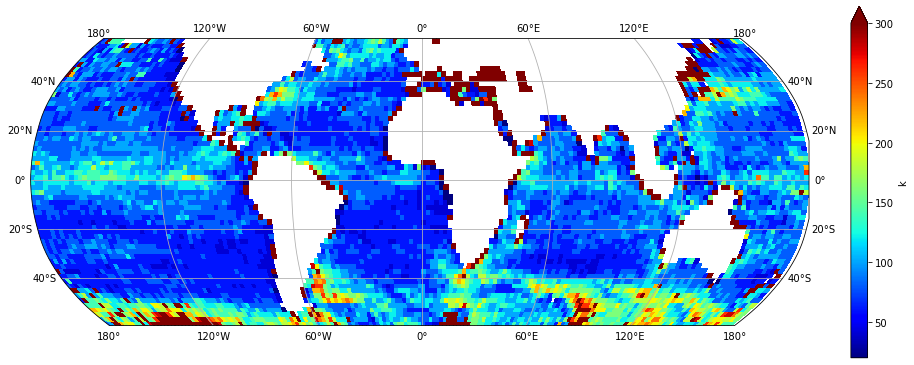

In [45]:
#.plot(y='lat_bins')
id_min = id_min.where(2*np.pi/id_min*1e-3>1)
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((2*np.pi/id_min*1e-3),colmap='jet',vlim=(20,300),central_longitude=0)

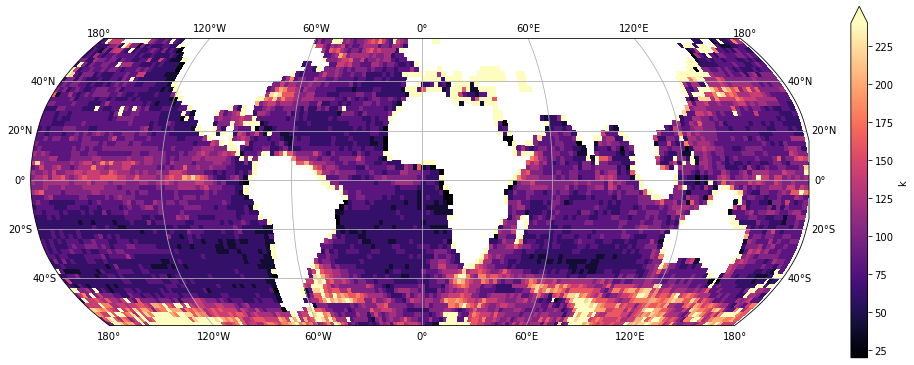

In [46]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((2*np.pi/id_min*1e-3),colmap='magma',vlim=(20,240),central_longitude=0)

In [45]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
k = id_min # rad/m


# filter
bandwidth = 0.4 # cpd
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=(["lon",'lat'],k.values), Ubar=(["lon",'lat'], np.sqrt(Ubar)),
                     Tbar=(["lon",'lat'], Tebar), U=(["lon",'lat'], U_bis)))
ds = ds.chunk({"lon":10,'lat':10})


ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    k        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [46]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']


In [47]:
El = El.compute()

El = El.rename({'lon':'lon_bins','lat':'lat_bins'}
              ).assign_coords({'lon_bins':dsE_out.lon_bins,'lat_bins':dsE_out.lat_bins})

In [48]:
Ee = Ee.compute()

Ee = Ee.rename({'lon':'lon_bins','lat':'lat_bins'}
              ).assign_coords({'lon_bins':dsE_out.lon_bins,'lat_bins':dsE_out.lat_bins})

Text(0.5, 1.0, 'Lagrangian estimation ratio')

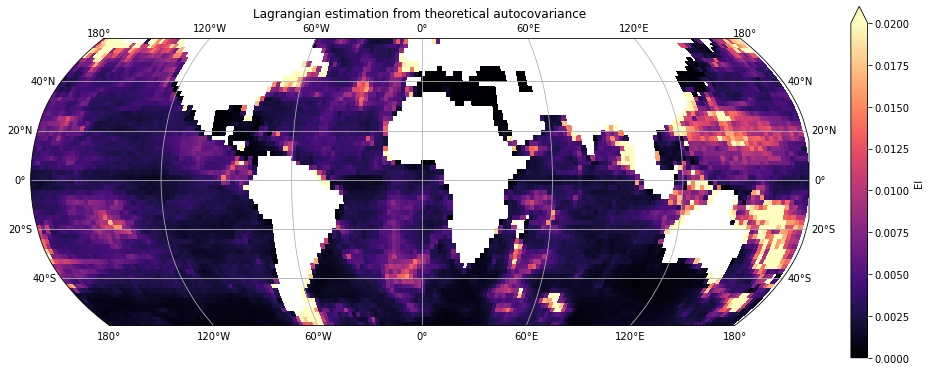

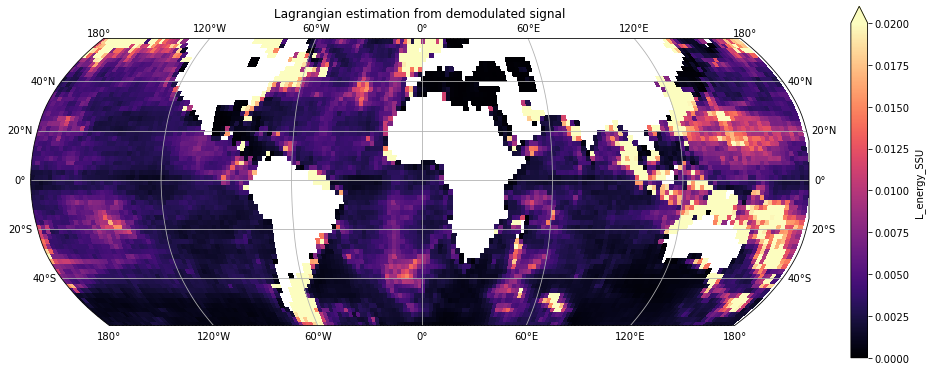

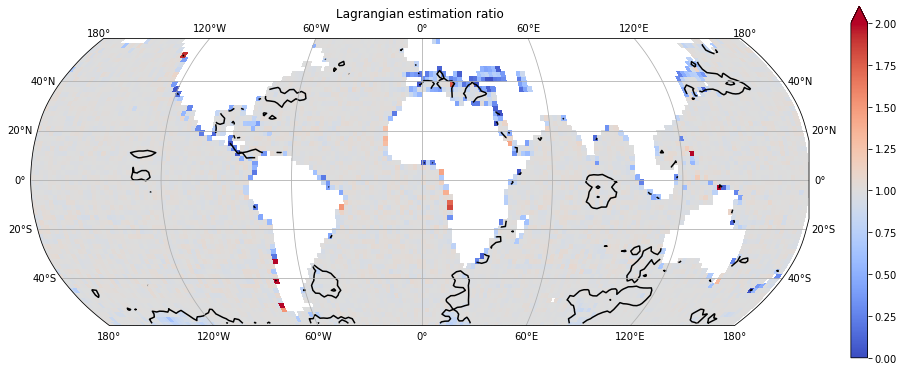

In [49]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(El,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))
dsE_out.sel(param='T').parameters.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

ax.set_title('Lagrangian estimation ratio')

Text(0.5, 1.0, 'Lagrangian over Eulerian estimation ratio')

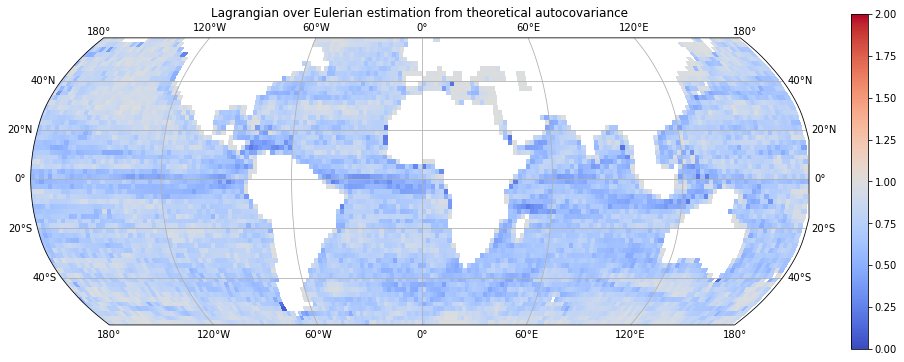

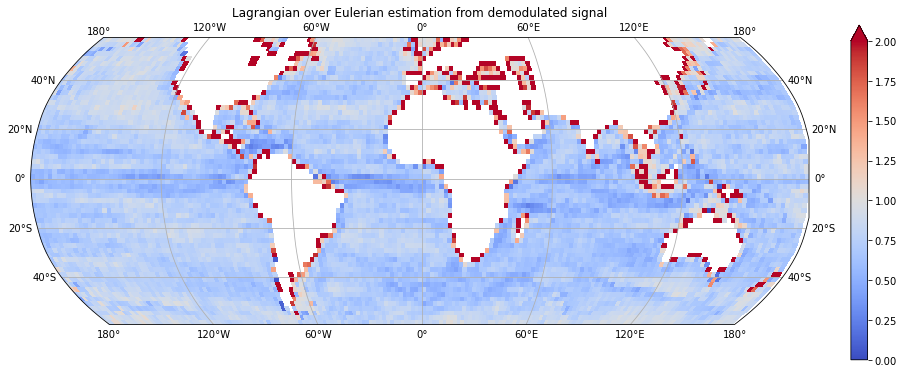

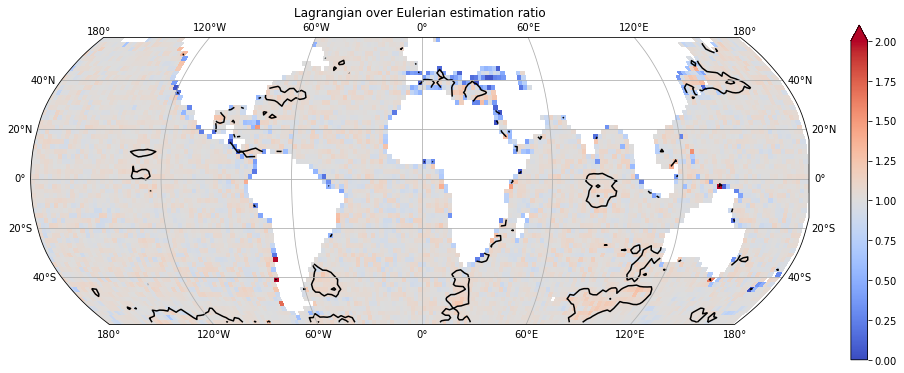

In [32]:

fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(El/Ee,colmap='coolwarm',vlim=(0,2))
ax.set_title('Lagrangian over Eulerian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
ax.set_title('Lagrangian over Eulerian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((El/Ee)/(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU),colmap='coolwarm',vlim=(0,2))
dsE_out.sel(param='T').parameters.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

ax.set_title('Lagrangian over Eulerian estimation ratio')

In [134]:
day2sec = 24*3600
param_kvt = (dsE_low_out.sel(param='V')*dsE_low_out.sel(param='T')*day2sec*k).parameters

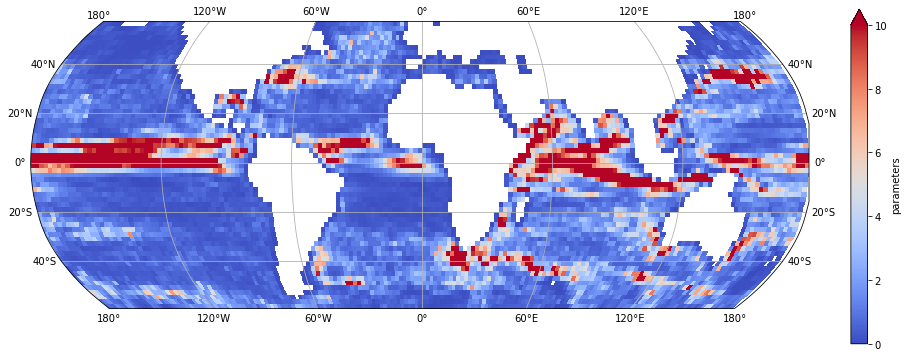

In [135]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(param_kvt,colmap='coolwarm',vlim=(0,10))

In [136]:
hf_dl2#.L_energy_SSU

<xarray.Dataset>
Dimensions:       (lon_bins: 179, lat_bins: 59)
Coordinates:
  * lon_bins      (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins      (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
Data variables:
    E_count       (lon_bins, lat_bins) int64 ...
    E_energy_SSU  (lon_bins, lat_bins) float64 0.001649 0.001448 ... 0.01921
    L_energy_SSU  (lon_bins, lat_bins) float64 ...
    waterdepth    (lon_bins, lat_bins) float64 ...
    L_count       (lon_bins, lat_bins) int64 ...

Text(0.5, 1.0, 'Lagrangian over Eulerian tidal variance (from analytical prediction)')

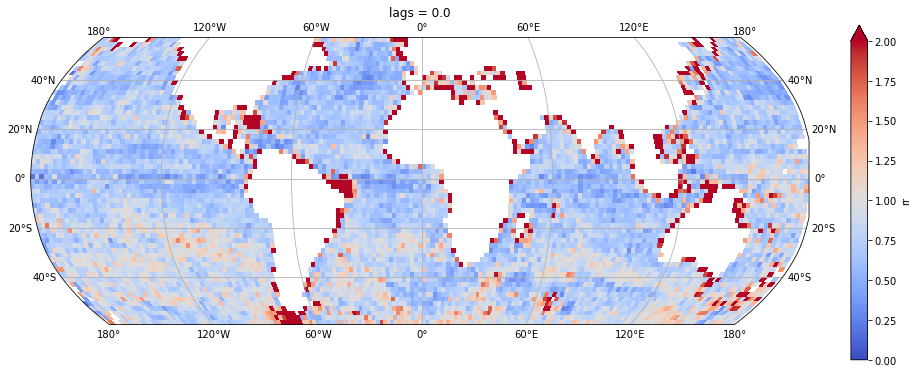

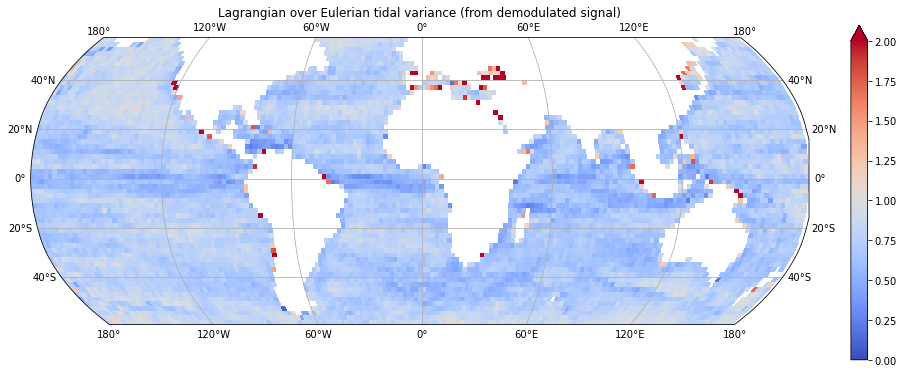

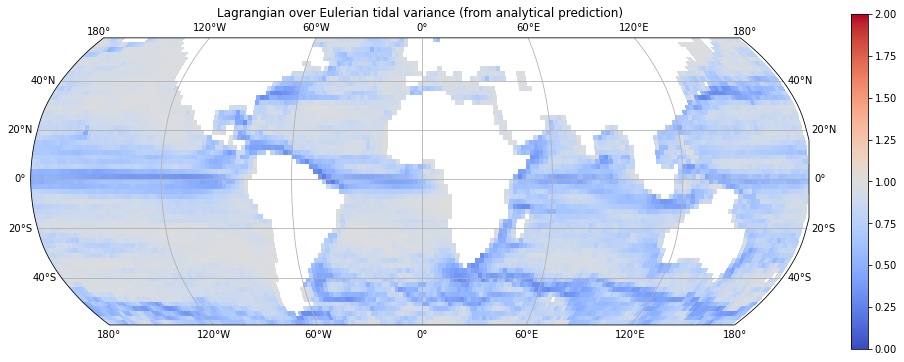

In [137]:

fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((dsL/dsE).rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))
#ax.set_title('Lagrangian estimation of decorrelation timescale')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU).where(hf_dl2.waterdepth>500),colmap='coolwarm',vlim=(0,2))
ax.set_title('Lagrangian over Eulerian tidal variance (from demodulated signal)')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((ds_predict.El/ds_predict.Ee),colmap='coolwarm',vlim=(0,2))
ax.set_title('Lagrangian over Eulerian tidal variance (from analytical prediction)')

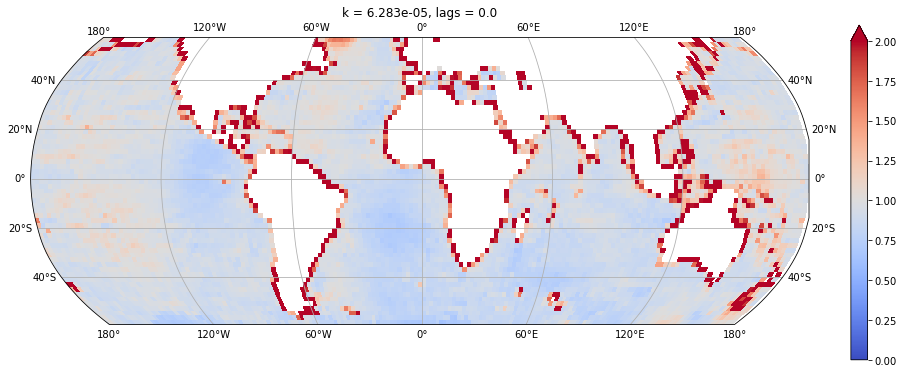

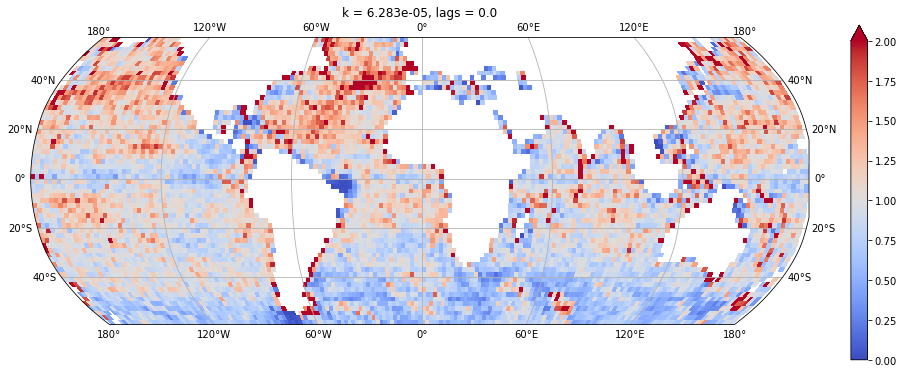

In [138]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/(2*dsE.rr.isel(lags=0)),colmap='coolwarm',vlim=(0,2))

fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El/(2*dsL.rr.isel(lags=0)),colmap='coolwarm',vlim=(0,2))

### Erreurs sur T tilde (jacobienne fit)

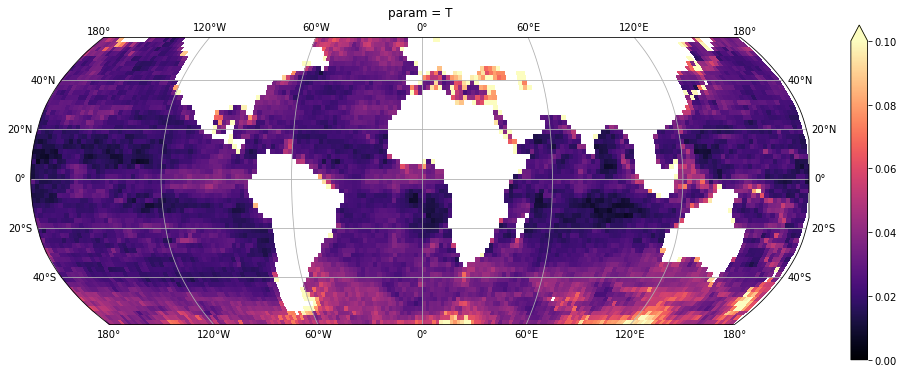

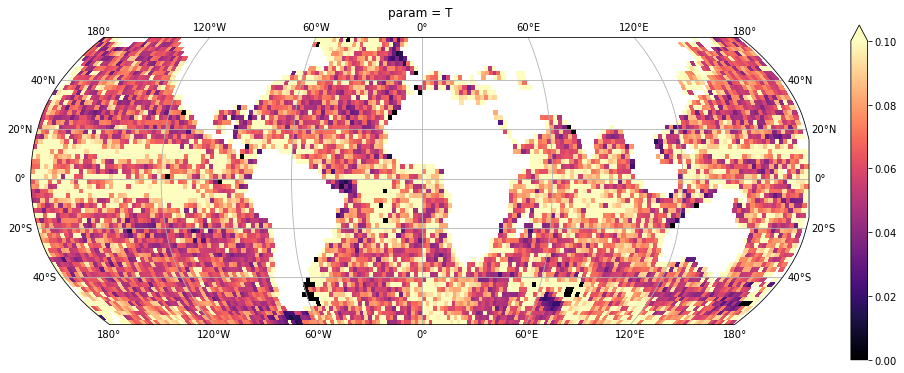

In [178]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(dsE_out.sel(param='T').error/dsE_out.sel(param='T').parameters
                   ,colmap='magma',vlim=(0,0.1))

fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(dsL_out.sel(param='T').error/dsL_out.sel(param='T').parameters
                   ,colmap='magma',vlim=(0,0.1))

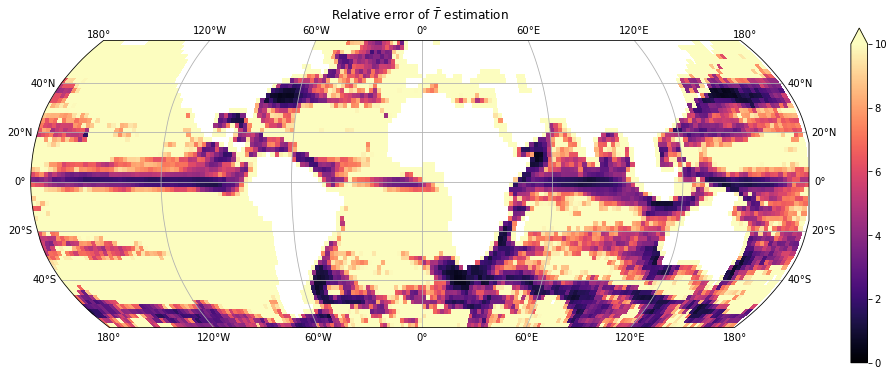

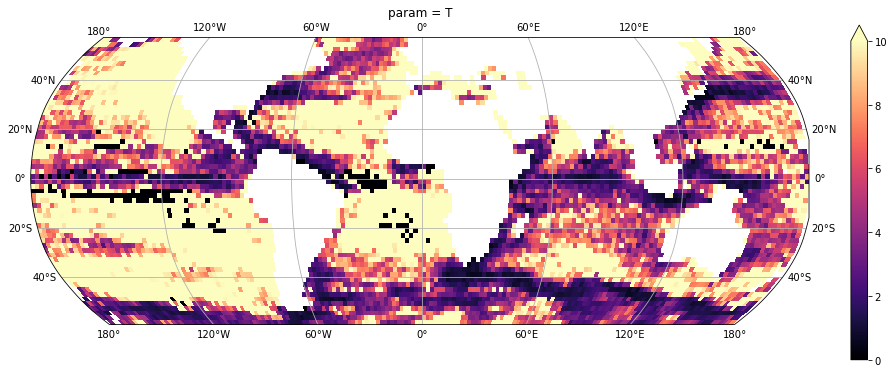

In [51]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(dsE_low_out.sel(param='T').error/dsE_low_out.sel(param='T').parameters
                   ,colmap='magma',vlim=(0,10))
ax.set_title(r'Relative error of $\bar T$ estimation')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(dsL_low_out.sel(param='T').error/dsL_low_out.sel(param='T').parameters
                   ,colmap='magma',vlim=(0,10))

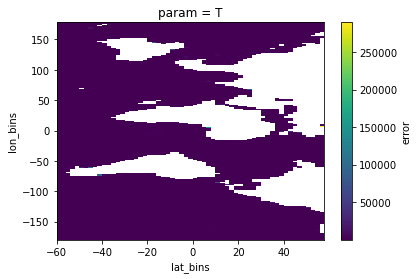

In [60]:
dsE_low_out.sel(param='T').error.plot()

In [61]:
Te = (dsE_out.sel(param='T').parameters).values
Ubar = low_dl2.L_variance_SSU.values
Tbar = (dsE_low_out.sel(param='T').parameters+dsE_low_out.sel(param='T').error).values

In [62]:
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar)),
                     Tbar=(["lon",'lat'], Tbar), U=(["lon",'lat'], U_bis)))

In [63]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10)

In [64]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

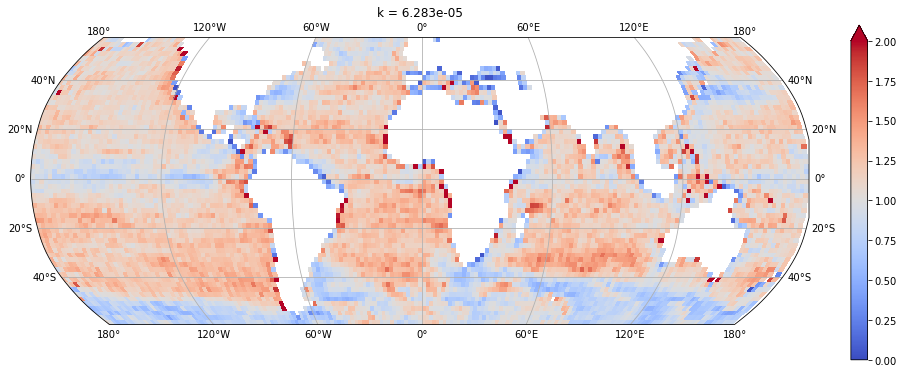

In [65]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((ds_predict.El/ds_predict.Ee)/(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU)
                   ,colmap='coolwarm',vlim=(0,2))



#### Test cells

In [138]:
dsE_pred = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Uebar)),
                     Tbar=(["lon",'lat'], Tebar), U=(["lon",'lat'], U)))

dsL_pred_v2 = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar.T)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))

dsL_pred_v3 = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar.T)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U_bis)))

In [139]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, dsE_pred, U=dsE_pred.U)

In [106]:
Ee_v2,El_v2,ratio_v2 = get_lagrangian_energy_loss(omega, bandwidth, dsL_pred_v2, U=dsL_pred_v2.U)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [107]:
Ee_v3,El_v3,ratio_v3 = get_lagrangian_energy_loss(omega, bandwidth, dsL_pred_v3, U=dsL_pred_v3.U)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [141]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})
ds_predict_v2 = xr.Dataset({'Ee':Ee_v2,'El':El_v2,'ratio':ratio_v2})
ds_predict_v3 = xr.Dataset({'Ee':Ee_v3,'El':El_v3,'ratio':ratio_v3})
ds_predict

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Coordinates:
    T        (lon, lat) float64 22.08 28.25 25.03 49.48 ... 73.3 36.65 71.84
    k        float64 6.283e-05
    Ubar     (lon, lat) float64 0.1442 0.1707 0.2903 ... 0.1142 0.1224 0.1005
    Tbar     (lon, lat) float64 7.559 5.278 9.05 9.892 ... 3.554 6.43 8.81 7.332
Dimensions without coordinates: lon, lat
Data variables:
    Ee       (lon, lat) float64 0.0004122 0.0003483 ... 0.004912 0.005193
    El       (lon, lat) float64 0.0003679 0.0002911 ... 0.004617 0.005061
    ratio    (lon, lat) float64 0.8925 0.8357 0.5837 ... 0.9561 0.9398 0.9746

In [142]:
ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

ds_predict_v2 = ds_predict_v2.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict_v2 = ds_predict_v2.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

ds_predict_v3 = ds_predict_v3.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict_v3 = ds_predict_v3.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

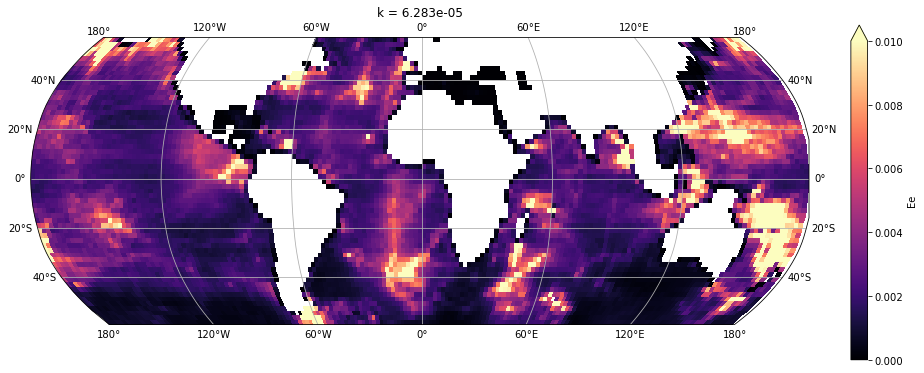

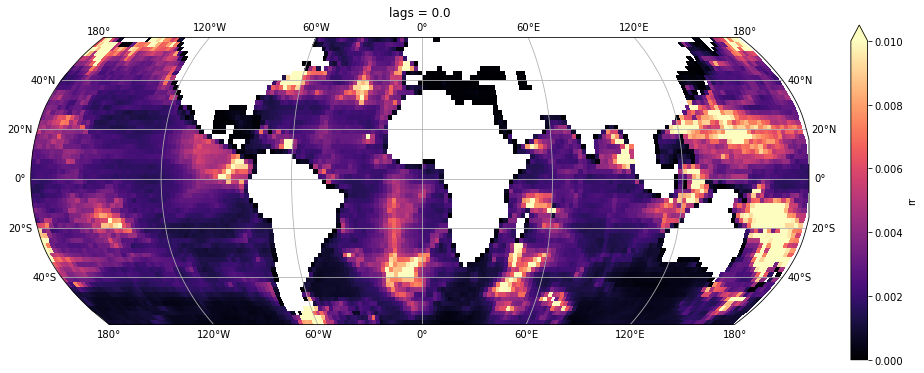

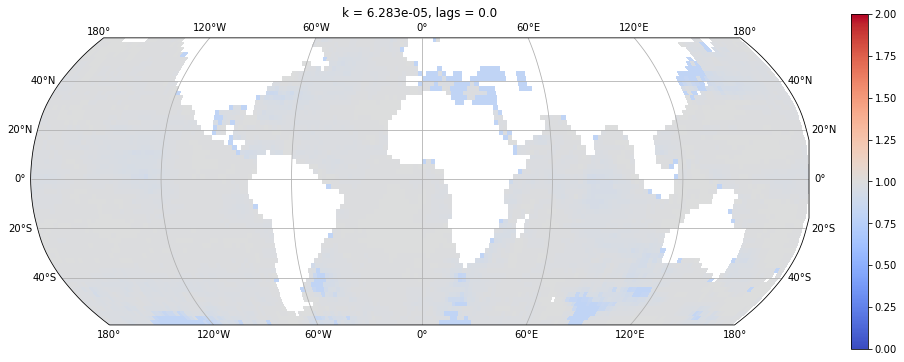

In [143]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.Ee,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsE.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.Ee/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

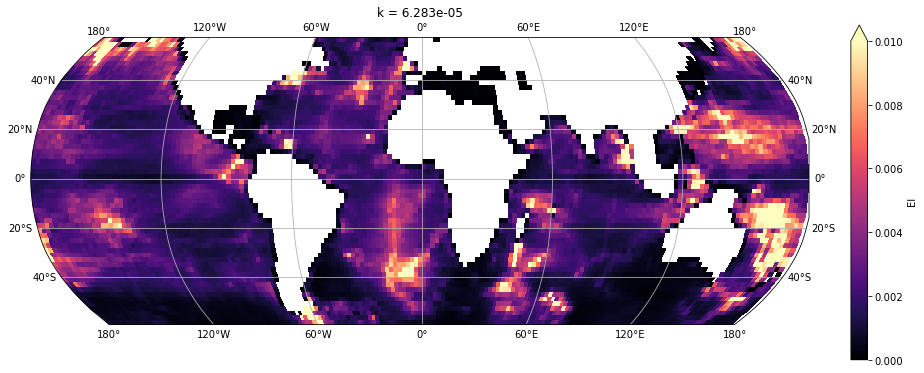

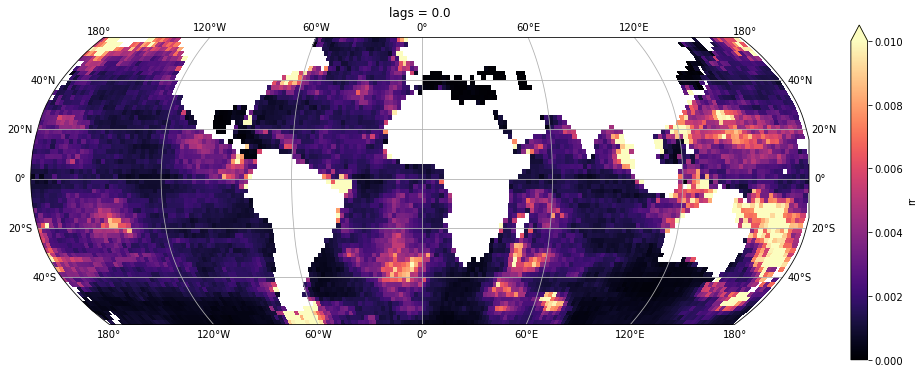

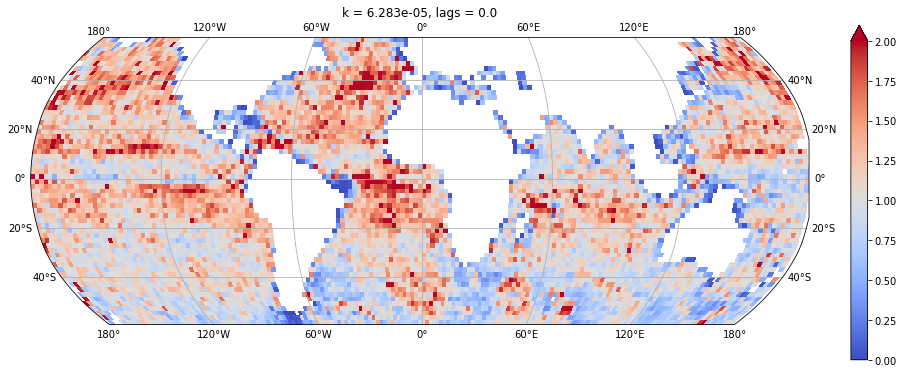

In [144]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.El,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict.El/dsL.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

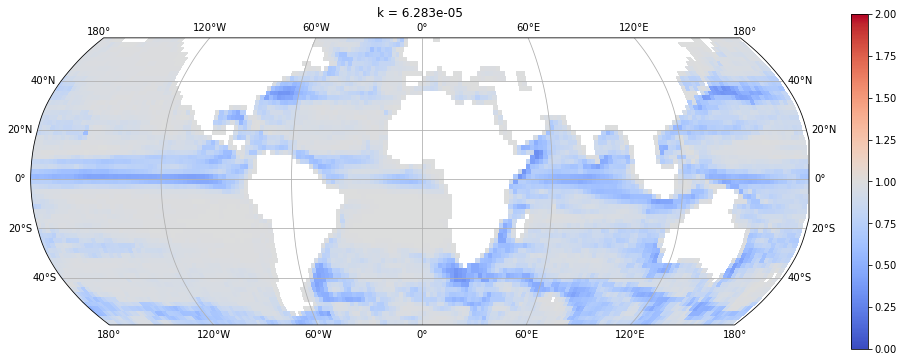

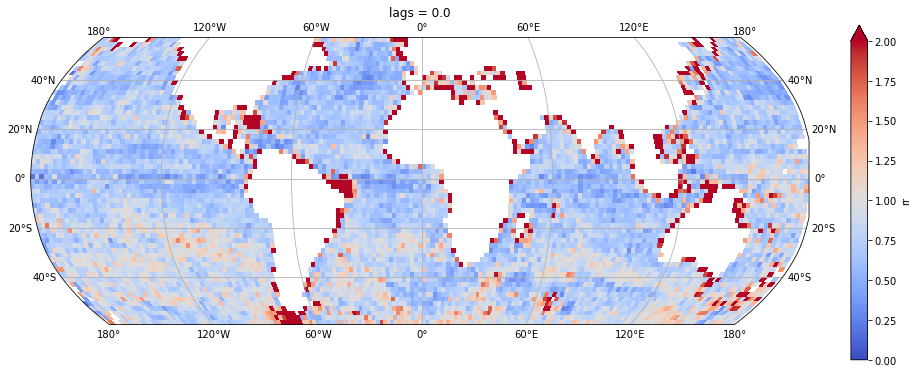

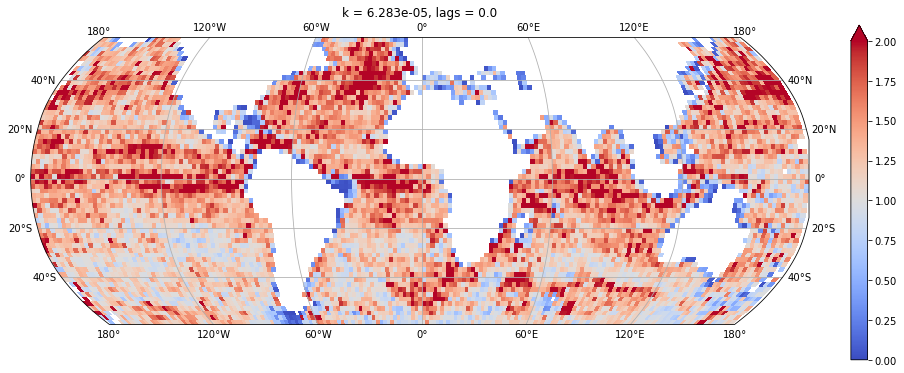

In [145]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict.El/ds_predict.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0)/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict.El*dsE.rr.isel(lags=0))/(ds_predict.El*dsL.rr.isel(lags=0)),colmap='coolwarm',vlim=(0,2))

In [114]:
### Third version

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05'}, xlabel='lon_bins', ylabel='lat_bins'>)

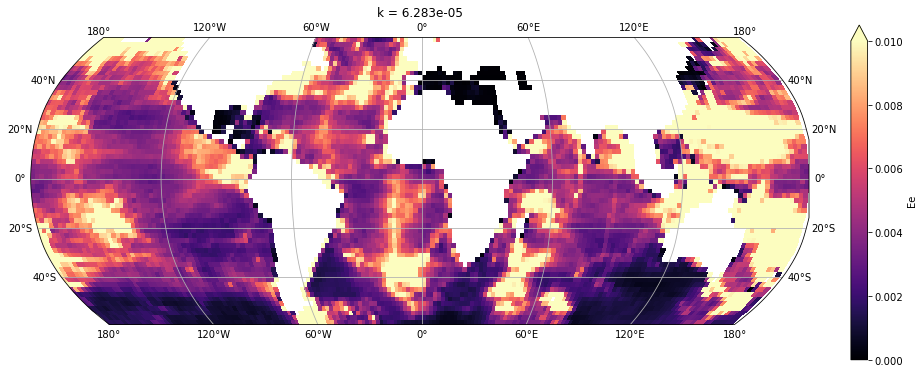

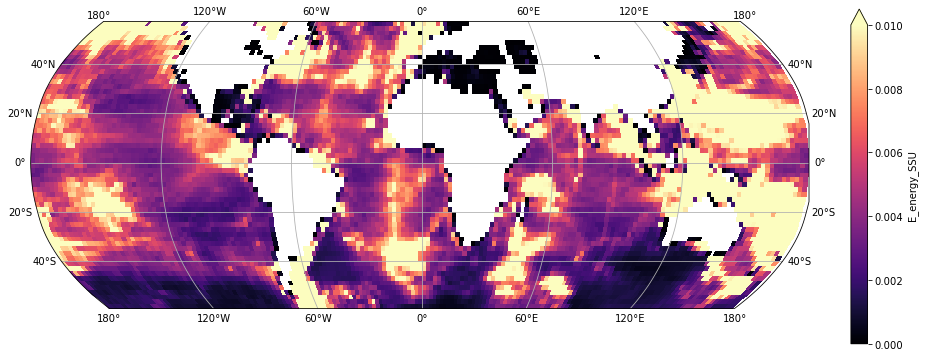

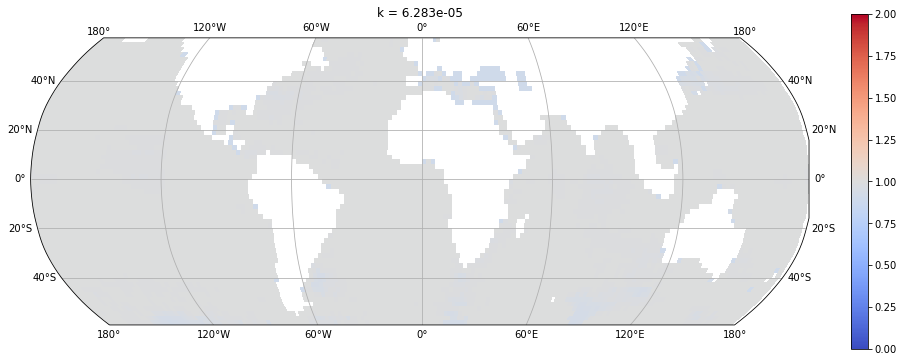

In [115]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.Ee,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.E_energy_SSU,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.Ee/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05'}, xlabel='lon_bins', ylabel='lat_bins'>)

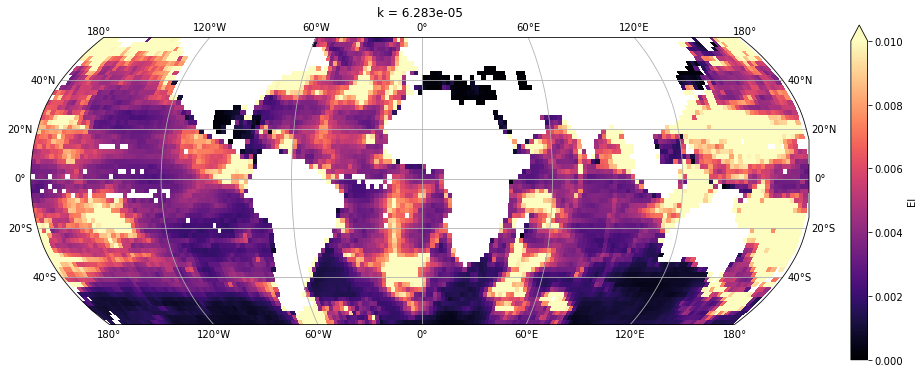

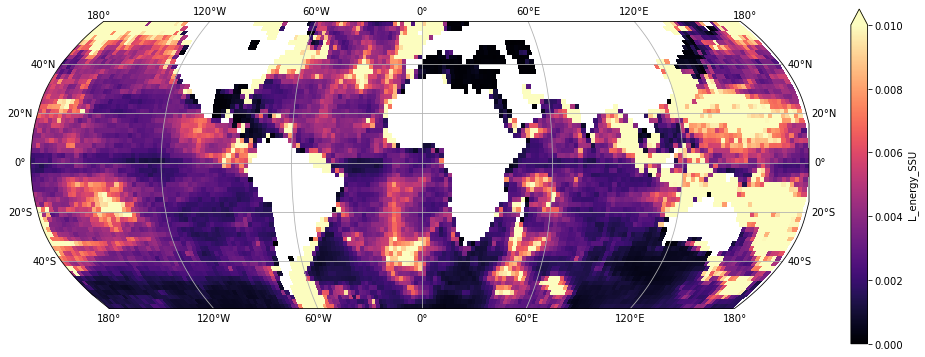

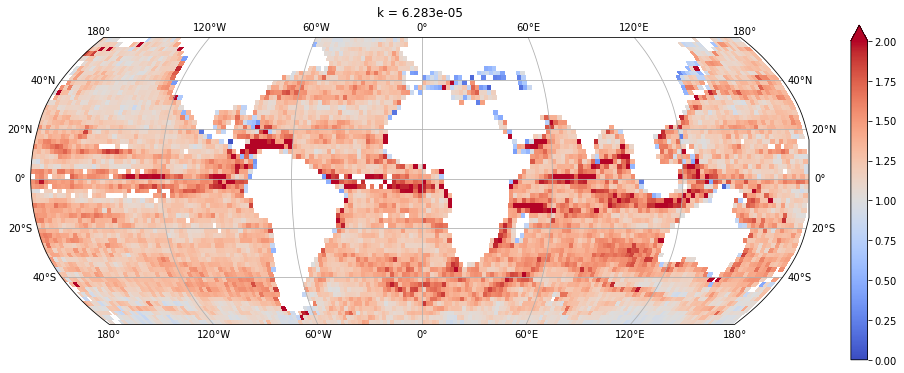

In [116]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.El,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v3.El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05'}, xlabel='lon_bins', ylabel='lat_bins'>)

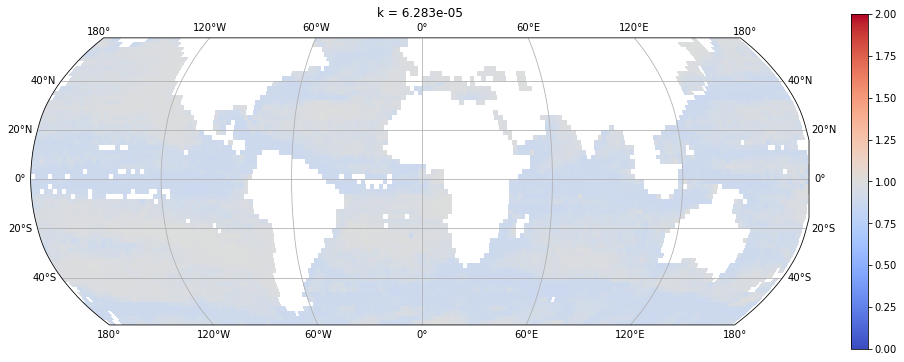

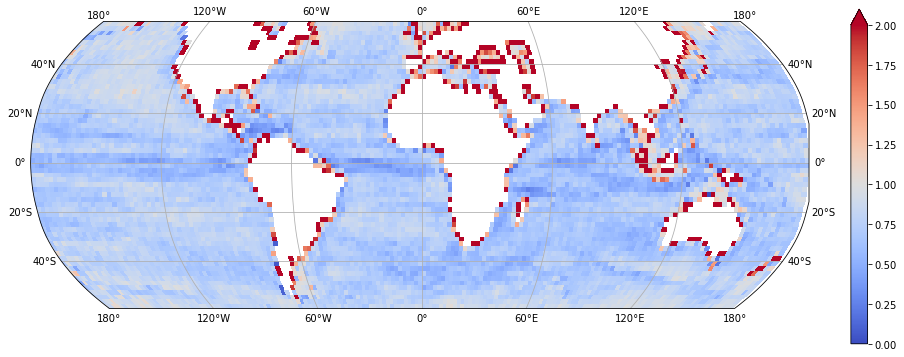

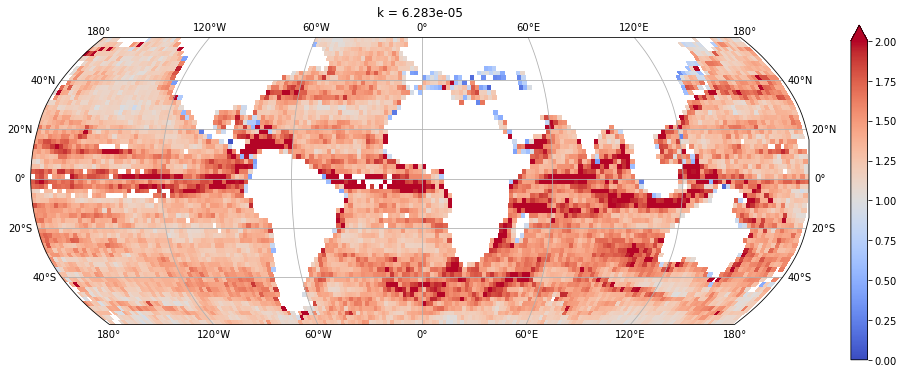

In [117]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict_v3.El/ds_predict_v3.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict_v3.El*hf_dl2.E_energy_SSU)/(ds_predict_v3.El*hf_dl2.L_energy_SSU),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

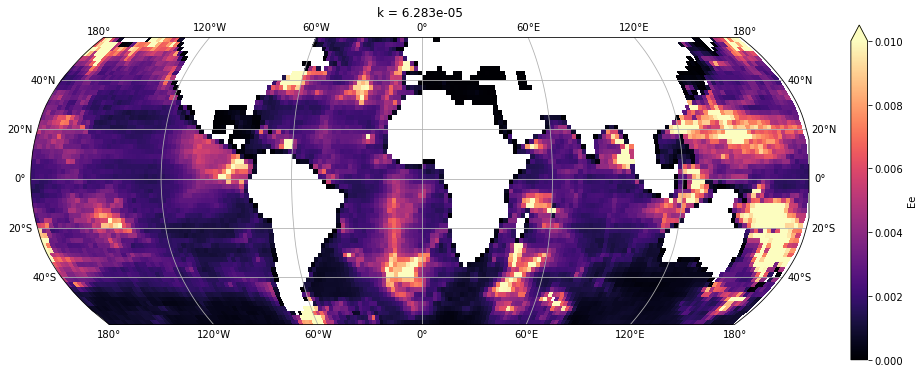

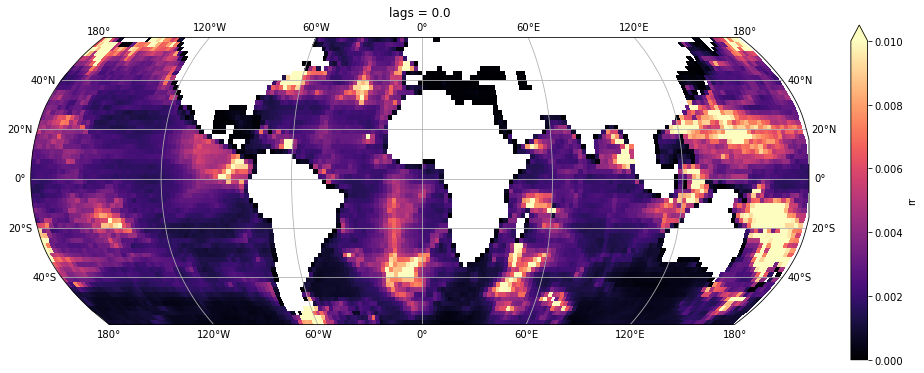

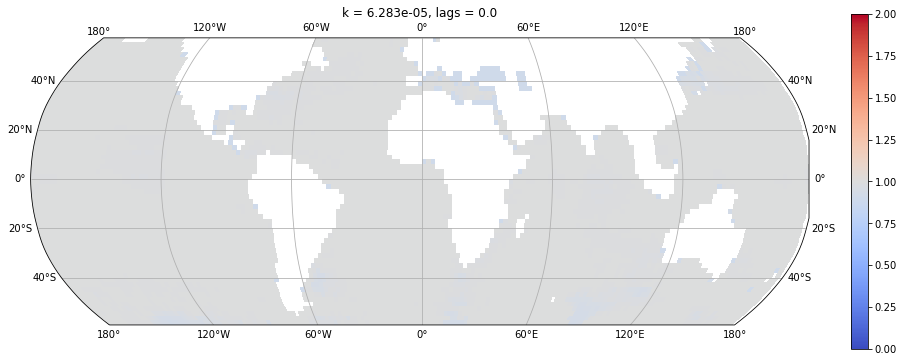

In [118]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.Ee,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsE.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.Ee/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

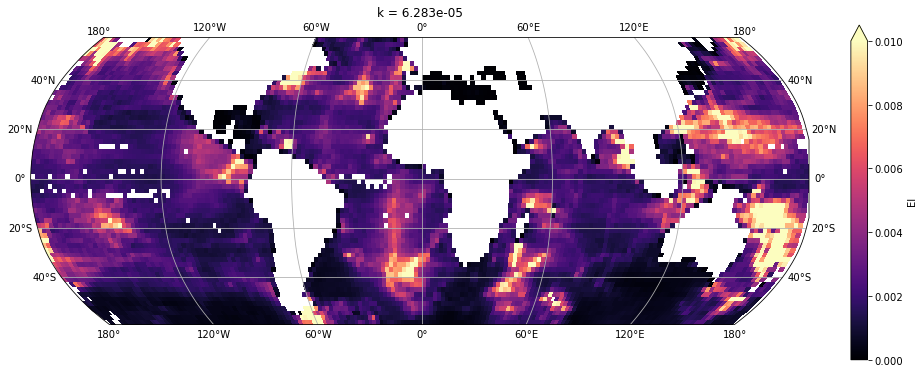

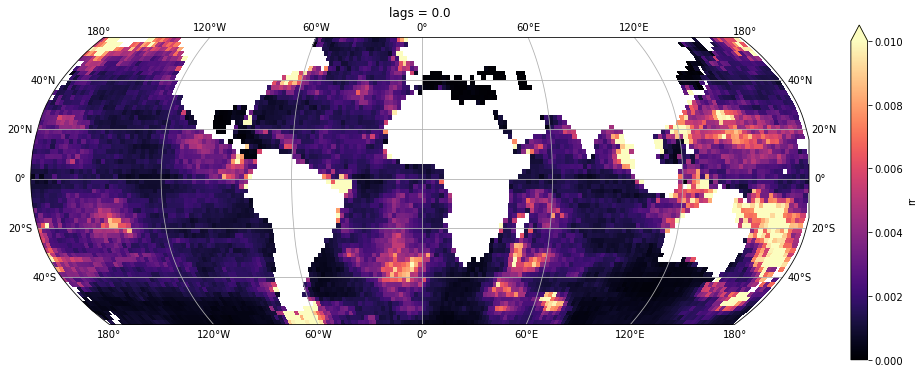

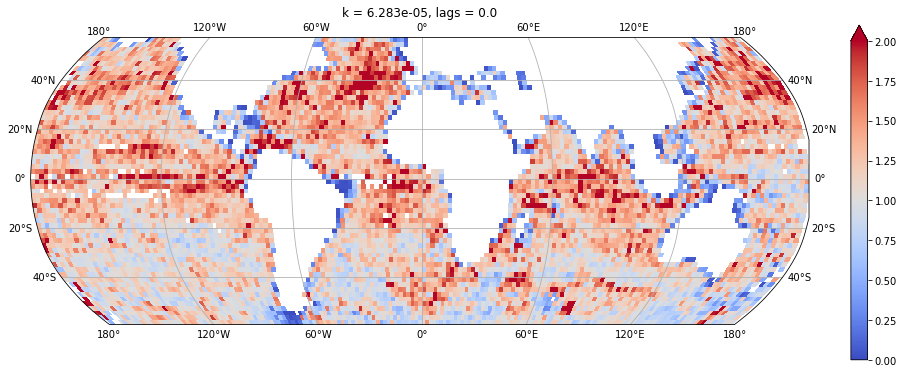

In [78]:
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.El,colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0),colmap='magma',vlim=(0,0.01))
fig = plt.figure(figsize=(15,15))
plot_maps(2*ds_predict_v2.El/dsL.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))

(<Figure size 1080x1080 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'k = 6.283e-05, lags = 0.0'}, xlabel='lon_bins', ylabel='lat_bins'>)

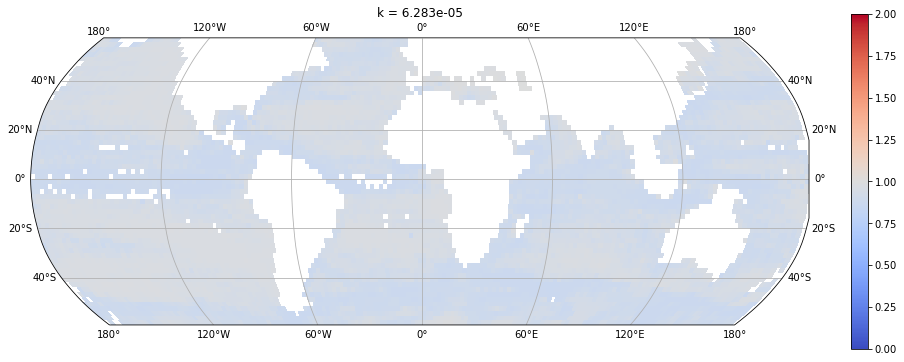

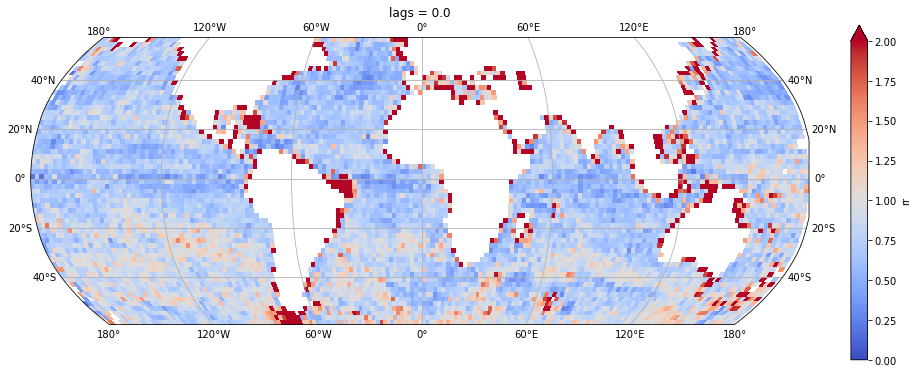

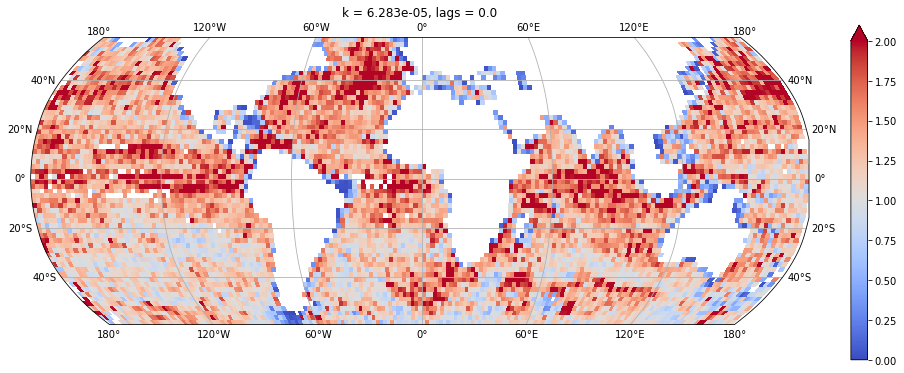

In [79]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict_v2.El/ds_predict_v2.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(dsL.rr.isel(lags=0)/dsE.rr.isel(lags=0),colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict_v2.El*dsE.rr.isel(lags=0))/(ds_predict_v2.El*dsL.rr.isel(lags=0))
          ,colmap='coolwarm',vlim=(0,2))

In [83]:
T = 20
dsL_pred_v3_bis = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar.T)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U_bis)))

In [ ]:
Ee_bis,El_bis,ratio_bis = get_lagrangian_energy_loss(omega, bandwidth, dsL_pred_v3_bis, U=dsL_pred_v3_bis.U)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [ ]:
ds_predict_bis = xr.Dataset({'Ee':Ee_bis,'El':El_bis,'ratio':ratio_bis})
ds_predict_bis = ds_predict_bis.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict_bis = ds_predict_bis.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [ ]:
fig = plt.figure(figsize=(15,15))
plot_maps(ds_predict_bis.El/ds_predict_bis.Ee,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
fig = plt.figure(figsize=(15,15))
plot_maps((ds_predict_bis.El*hf_dl2.E_energy_SSU)/(ds_predict_bis.El*hf_dl2.L_energy_SSU)
          ,colmap='coolwarm',vlim=(0,2))

In [127]:
cluster.close()

##### Zoom Guf stream

In [138]:
lat0,lat1 = 34,44
lon0,lon1 = -78,-66

In [156]:
dsi_hf = hf_dl2.sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))
dsi_lf = low_dl2.sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))

dsi_hf_out = xr.merge([dsE_out.parameters,dsL_out.parameters.rename('L_parameters')]
                     ).sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))
dsi_lf_out = xr.merge([dsE_low_out.parameters,dsL_low_out.parameters.rename('L_parameters')]
                     ).sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))

In [157]:
dsi_hf_out

<xarray.Dataset>
Dimensions:       (lon_bins: 6, lat_bins: 5, param: 2)
Coordinates:
  * lon_bins      (lon_bins) float64 -77.0 -75.0 -73.0 -71.0 -69.0 -67.0
  * lat_bins      (lat_bins) float64 35.0 37.0 39.0 41.0 43.0
  * param         (param) <U1 'T' 'V'
Data variables:
    parameters    (lon_bins, lat_bins, param) float64 nan nan nan ... nan nan
    L_parameters  (lat_bins, lon_bins, param) float64 nan nan 2.5 ... nan nan

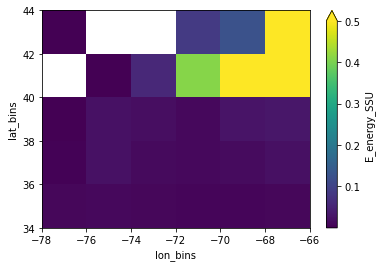

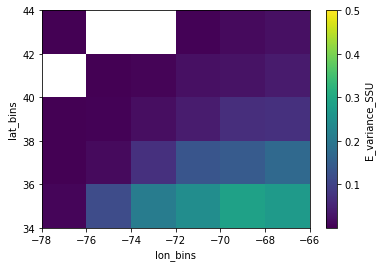

In [149]:
dsi_hf.E_energy_SSU.plot(y='lat_bins',vmax=0.5)
plt.figure()
dsi_lf.E_variance_SSU.plot(y='lat_bins',vmax=0.5)

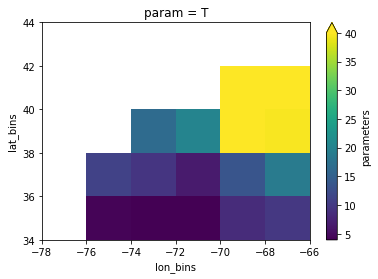

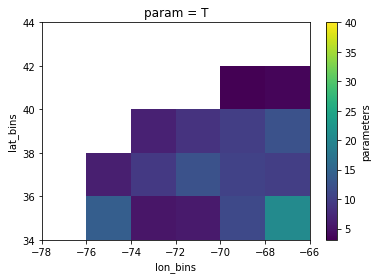

In [162]:
dsi_hf_out.sel(param='T').parameters.plot(y='lat_bins',vmax=40)
plt.figure()
dsi_lf_out.sel(param='T').parameters.plot(y='lat_bins',vmax=40)

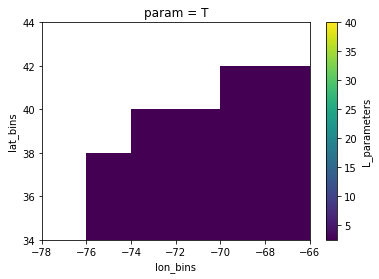

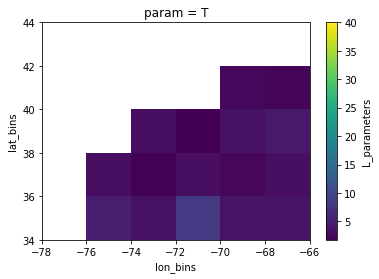

In [163]:
dsi_hf_out.sel(param='T').L_parameters.plot(y='lat_bins',vmax=40)
plt.figure()
dsi_lf_out.sel(param='T').L_parameters.plot(y='lat_bins',vmax=40)

In [47]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
